In [1]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_wds,read_orb6
from astrometry_model import astrometry_model,triple_model,quad_model,triple_model_circular,quad_model_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy import pyasl
%matplotlib inline

In [2]:
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    if np.isnan(theta):
        theta_new=theta
    return(r,theta_new)

In [3]:
def add_planet(period,wobble,bigomega,inc,t0,epochs):
    omega = 0
    ecc = 0
    bigomega = bigomega
    inc = inc

    ## other method:
    ke = pyasl.KeplerEllipse(wobble,period,e=ecc,Omega=bigomega,i=inc,w=omega,tau=t0)
    pos = ke.xyzPos(epochs)
    xx = pos[::,1]
    yy = pos[::,0]
    return(xx,yy)

In [4]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/wds_targets'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [5]:
###########################################
## Specify Target
###########################################
target_hd = '140159'

emethod = 'n'
mirc_scale = 'n'

query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

try:
    print(target_wds)
except:
    print('No WDS number queried')
    target_wds = input('Enter WDS: ')

HIP 76852
WDS 15416+1940
15416+1940


In [6]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

reading chi2 errors


In [7]:
### correct PAs based on precession
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [8]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = 'y'

vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

Closest factor for 58222.3507 is 0.8345060481951805 days away
   date      etalon factor
58223.4082 1.0025109719562986
58158.571 1.0026292119995914
59042.1973 0.9994391329775113
58636.3086 0.9992840806836619
58635.2767 0.9992805209312889
59044.2481 0.9994792330971126
59004.2807 0.9995092694376418
58703.1746 0.99933618747475
58222.3507 1.0025109719562986
59196.598 0.9995521629823048
58693.1558 0.9993432836567131
59304.4024 0.9994506844380842
Applying etalon correction


Number of WDS data points = 48


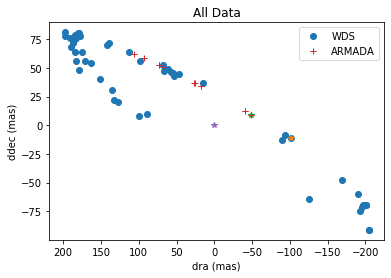

In [9]:
###########################################
## Read in WDS data - and plot to check
###########################################
file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds)))
weight = 10
dtype = 'S'

t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)
print('Number of WDS data points = %s'%len(p_wds))

## correct WDS for PA
theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)
idx = np.argmin(t)

plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [10]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
210.32999999999998 21.958904109589042 0.0941 83.608 80.5 69.684 54180.0
--------------------------


In [11]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

In [12]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                       emaj,emin,epa),
                            nan_policy='omit')
    result = minner.minimize()
    # write error report
    print(report_fit(result))

    ## plot fit
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

## First Inject a Single Planet as Test

In [ ]:
############################################
## ADD A FAKE PLANET
############################################
print('ADDING FAKE PLANET')
pper = 100
psem = 0.5

bigw_injected1 = np.random.uniform(0,360)
inc_injected1 = np.random.uniform(0,180)
t0_injected1 = np.random.uniform(min(t),max(t))

planet_xy = add_planet(pper,psem,bigw_injected1,inc_injected1,t0_injected1,t)
planet_xy_wds = add_planet(pper,psem,bigw_injected1,inc_injected1,t0_injected1,t_wds)
planet_xy_all = add_planet(pper,psem,bigw_injected1,inc_injected1,t0_injected1,t_all)

xpos += planet_xy[0]
ypos += planet_xy[1]
xpos_wds += planet_xy_wds[0]
ypos_wds += planet_xy_wds[1]
xpos_all += planet_xy_all[0]
ypos_all += planet_xy_all[1]

In [ ]:
###########################################
## Do a least-squares fit
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
params.add('mirc_scale', value= 1.0, vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [ ]:
result.params['inc']

In [ ]:
resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                            error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-len(result.params))
print('-'*10)
print('chi2 armada = %s'%chi2_armada)

In [ ]:
scale=1
if chi2_armada<1.0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)

In [ ]:
## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.show()

plt.errorbar(t,xresid,yerr=error_maj/scale*np.sin(error_deg*np.pi/180),fmt='o')
plt.xlabel('Time')
plt.ylabel('dRA (mas)')
plt.show()

plt.errorbar(t,yresid,yerr=error_maj/scale*np.cos(error_deg*np.pi/180),fmt='o')
plt.xlabel('Time')
plt.ylabel('dRA (mas)')
plt.show()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

In [ ]:
##########################################
## Grid Search for Additional Companions
##########################################

## New test -- try period spacing from PHASES III paper
time_span = max(t) - min(t)
print('Time span of data = %s days'%time_span)
f = 5
min_per = 2
max_k = int(2*f*time_span / min_per)
k_range = np.arange(max_k)[:-1] + 1
P2 = 2*f*time_span / k_range
print('Min/Max period (days) = %s / %s ; %s steps'%(min(P2),max(P2),len(k_range)))

ss = 0.01
se = 1
#P2 = np.linspace(ps,pe,steps)
#P2 = np.logspace(np.log10(ps),np.log10(pe),1000)

a2 = resids_median/1000
if np.isnan(a2):
    a2=1
#T2 = 55075

P2 = np.logspace(0,2.5,200)

In [ ]:
print('Grid Searching over period')
params_inner=[]
params_outer=[]
chi2 = []

for period in tqdm(P2):
    params_inner_n=[]
    params_outer_n=[]
    chi2_n = []

    for i in np.arange(20):
        ## randomize orbital elements
        bigw2 = np.random.uniform(0,360)
        inc2 = np.random.uniform(0,180)
        T2 = np.random.uniform(58000,60000)

        params = Parameters()
        params.add('w',   value= w_start, min=0, max=360)
        params.add('bigw', value= bigw_start, min=0, max=360)
        params.add('inc', value= inc_start, min=0, max=180)
        params.add('e', value= e_start, min=0, max=0.99)
        params.add('a', value= a_start, min=0)
        params.add('P', value= P_start, min=0)
        params.add('T', value= T_start, min=0)
        params.add('w2',   value= 0, vary=False)
        params.add('bigw2', value= bigw2, min=0, max=360)
        params.add('inc2', value= inc2, min=0, max=180)
        params.add('e2', value= 0, vary=False)
        params.add('a2', value= a2, min=0)
        params.add('P2', value= period, vary=False)
        params.add('T2', value= T2, min=0)
        
        if mirc_scale == 'y':
            params.add('mirc_scale', value= 1.0)
        else:
            params.add('mirc_scale', value= 1.0, vary=False)

        #params.add('pscale', value=1)

        #do fit, minimizer uses LM for least square fitting of model to data
        minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                           error_maj_all,error_min_all,
                                                           error_pa_all),
                          nan_policy='omit')
        result = minner.leastsq(xtol=1e-5,ftol=1e-5)
        params_inner_n.append([result.params['P2'],result.params['a2'],result.params['e2'],result.params['w2']
                            ,result.params['bigw2'],result.params['inc2'],result.params['T2']])
        params_outer_n.append([result.params['P'],result.params['a'],result.params['e'],result.params['w']
                            ,result.params['bigw'],result.params['inc'],result.params['T']])
        chi2_n.append(result.chisqr)

    params_inner_n=np.array(params_inner_n)
    params_outer_n=np.array(params_outer_n)
    chi2_n = np.array(chi2_n)
    #chi2_noise_n = np.array(chi2_noise_n)

    idx = np.argmin(chi2_n)
    #idx_n = np.argmin(chi2_noise_n)
    chi2.append(chi2_n[idx])
    #chi2_noise.append(chi2_noise_n[idx_n])
    params_inner.append(params_inner_n[idx])
    params_outer.append(params_outer_n[idx])

In [ ]:
chi2 = np.array(chi2)
params_inner = np.array(params_inner)
params_outer = np.array(params_outer)

idx = np.argmin(chi2)
best_period = params_inner[:,0][idx]
print('Best Period = ', best_period)

In [ ]:
plt.plot(params_inner[:,0],1/chi2)
plt.plot([pper,pper],[min(1/chi2),max(1/chi2)],'--',label='%s uas'%(psem*1000))
plt.xlabel('Period (days)')
plt.ylabel('1/chi2')
plt.legend()
plt.show()

## Now Add 2 Planets

In [13]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

reading chi2 errors


In [14]:
### correct PAs based on precession
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [15]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = 'y'

vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

Closest factor for 58222.3507 is 0.8345060481951805 days away
   date      etalon factor
58223.4082 1.0025109719562986
58158.571 1.0026292119995914
59042.1973 0.9994391329775113
58636.3086 0.9992840806836619
58635.2767 0.9992805209312889
59044.2481 0.9994792330971126
59004.2807 0.9995092694376418
58703.1746 0.99933618747475
58222.3507 1.0025109719562986
59196.598 0.9995521629823048
58693.1558 0.9993432836567131
59304.4024 0.9994506844380842
Applying etalon correction


Number of WDS data points = 48


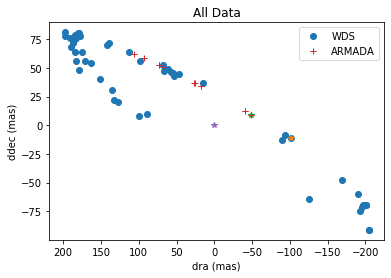

In [16]:
###########################################
## Read in WDS data - and plot to check
###########################################
file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds)))
weight = 10
dtype = 'S'

t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)
print('Number of WDS data points = %s'%len(p_wds))

## correct WDS for PA
theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)
idx = np.argmin(t)

plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [17]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
210.32999999999998 21.958904109589042 0.0941 83.608 80.5 69.684 54180.0
--------------------------


In [18]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

In [19]:
############################################
## ADD A FAKE PLANET
############################################
print('ADDING 2 FAKE PLANETS')
pper1 = 100
psem1 = 0.5

pper2 = 5
psem2 = 0.5

bigw_injected1 = np.random.uniform(0,360)
inc_injected1 = np.random.uniform(0,180)
t0_injected1 = np.random.uniform(min(t),max(t))
bigw_injected2 = np.random.uniform(0,360)
inc_injected2 = np.random.uniform(0,180)
t0_injected2 = np.random.uniform(min(t),max(t))

planet_xy = add_planet(pper1,psem1,bigw_injected1,inc_injected1,t0_injected1,t)
planet_xy_wds = add_planet(pper1,psem1,bigw_injected1,inc_injected1,t0_injected1,t_wds)
planet_xy_all = add_planet(pper1,psem1,bigw_injected1,inc_injected1,t0_injected1,t_all)
planet_xy2 = add_planet(pper2,psem2,bigw_injected2,inc_injected2,t0_injected2,t)
planet_xy2_wds = add_planet(pper2,psem2,bigw_injected2,inc_injected2,t0_injected2,t_wds)
planet_xy2_all = add_planet(pper2,psem2,bigw_injected2,inc_injected2,t0_injected2,t_all)

xpos += planet_xy[0] + planet_xy2[0]
ypos += planet_xy[1] + planet_xy2[1]
xpos_wds += planet_xy_wds[0] + planet_xy2_wds[0]
ypos_wds += planet_xy_wds[1] + planet_xy2_wds[1]
xpos_all += planet_xy_all[0] + planet_xy2_all[0]
ypos_all += planet_xy_all[1] + planet_xy2_all[1]



ADDING 2 FAKE PLANETS


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 120
    # variables        = 7
    chi-square         = 1516.83784
    reduced chi-square = 13.4233437
    Akaike info crit   = 318.426960
    Bayesian info crit = 337.939402
[[Variables]]
    w:           79.5049052 +/- 7.81535843 (9.83%) (init = 80.5)
    bigw:        69.7710911 +/- 0.13463392 (0.19%) (init = 69.684)
    inc:         83.7767014 +/- 0.15069508 (0.18%) (init = 83.608)
    e:           0.12157363 +/- 0.01643808 (13.52%) (init = 0.0941)
    a:           215.779372 +/- 2.51794874 (1.17%) (init = 210.33)
    P:           8019.36084 +/- 32.1097196 (0.40%) (init = 8015)
    T:           54139.2445 +/- 219.597989 (0.41%) (init = 54180)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, T)      =  0.998
    C(inc, a)    =  0.983
    C(inc, e)    =  0.967
    C(e, a)      =  0.945
    C(w, bigw)   =  0.917
    C(bigw, T)   =  0.910
   

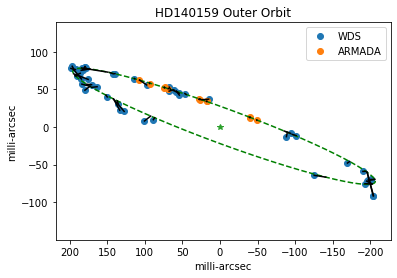

In [20]:
###########################################
## Do a least-squares fit
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
params.add('mirc_scale', value= 1.0, vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [21]:
resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                            error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-len(result.params))
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

----------
chi2 armada = 90.67620976796391
----------


In [22]:
scale=1
if chi2_armada<1.0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)


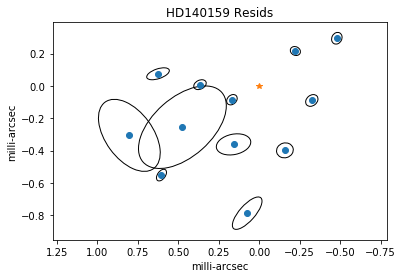

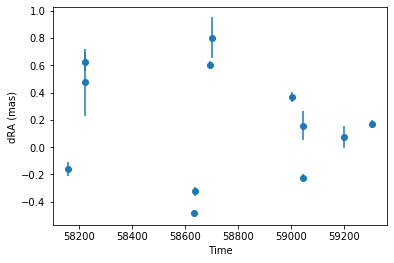

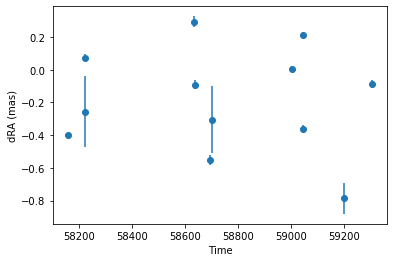

----------
Mean residual = 483.86 micro-as
----------


In [23]:
## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.show()

plt.errorbar(t,xresid,yerr=error_maj/scale*np.sin(error_deg*np.pi/180),fmt='o')
plt.xlabel('Time')
plt.ylabel('dRA (mas)')
plt.show()

plt.errorbar(t,yresid,yerr=error_maj/scale*np.cos(error_deg*np.pi/180),fmt='o')
plt.xlabel('Time')
plt.ylabel('dRA (mas)')
plt.show()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

a2 = resids_median/1000


## Test fitting routine

In [24]:
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().vms*1e-9)

113.77492377600001


In [30]:
niter = 20

params_inner1_test=np.zeros(shape=(niter,7))
params_inner2_test=np.zeros(shape=(niter,7))
params_outer_test=np.zeros(shape=(niter,7))
chi2_test = np.zeros(shape=niter)

for i in tqdm(np.arange(niter)):
    ## randomize orbital elements
    bigw2 = np.random.uniform(0,360)
    inc2 = np.random.uniform(0,180)
    T2 = np.random.uniform(58000,60000)
    bigw3 = np.random.uniform(0,360)
    inc3 = np.random.uniform(0,180)
    T3 = np.random.uniform(58000,60000)

    params = Parameters()
    params.add('w',   value= w_start, min=0, max=360)
    params.add('bigw', value= bigw_start, min=0, max=360)
    params.add('inc', value= inc_start, min=0, max=180)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
    params.add('w2',   value= 0, vary=False)
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('e2', value= 0, vary=False)
    params.add('a2', value= a2, min=0)
    params.add('P2', value= 5, vary=False)
    params.add('T2', value= T2, min=0)
        
    params.add('w3',   value= 0, vary=False)
    params.add('bigw3', value= bigw3, min=0, max=360)
    params.add('inc3', value= inc3, min=0, max=180)
    params.add('e3', value= 0, vary=False)
    params.add('a3', value= a2, min=0)
    params.add('P3', value= 100, vary=False)
    params.add('T3', value= T3, min=0)
        
    if mirc_scale == 'y':
        params.add('mirc_scale', value= 1.0)
    else:
        params.add('mirc_scale', value= 1.0, vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(quad_model_circular, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all),
                      nan_policy='omit')
    result = minner.leastsq(xtol=1e-5,ftol=1e-5)
    params_inner1_test[i] = [result.params['P3'],result.params['a3'],result.params['e3'],result.params['w3']
                        ,result.params['bigw3'],result.params['inc3'],result.params['T3']]
    params_inner2_test[i] = [result.params['P2'],result.params['a2'],result.params['e2'],result.params['w2']
                        ,result.params['bigw2'],result.params['inc2'],result.params['T2']]
    params_outer_test[i] = [result.params['P'],result.params['a'],result.params['e'],result.params['w']
                        ,result.params['bigw'],result.params['inc'],result.params['T']]
    chi2_test[i] = result.chisqr
    
    #print(process.memory_info().vms*1e-9)

idx = np.argmin(chi2_test)
#idx_n = np.argmin(chi2_noise_n)
chi2_quad_test = chi2_test[idx]
#chi2_noise.append(chi2_noise_n[idx_n])
params_inner1_test = params_inner1_test[idx]
params_inner2_test = params_inner2_test[idx]
params_outer_quad_test = params_outer_test[idx]

100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


In [31]:
param_names = ['P','a','e','w','bigw','i','T']
injected1 = [pper1,psem1,0,0,bigw_injected1,inc_injected1,t0_injected1]
injected2 = [pper2,psem2,0,0,bigw_injected2,inc_injected2,t0_injected2]

print('First inner companion')
for name,fit,inject in zip(param_names,params_inner1_test,injected1):
    print(name,',',fit,',',inject)

print('--'*10)
    
print('Second inner companion')
for name,fit,inject in zip(param_names,params_inner2_test,injected2):
    print(name,',',fit,',',inject)
    
print('--'*10)
print(chi2_quad_test / (2*len(xpos_all)-15))

First inner companion
P , 100.0 , 100
a , 0.5021769166291226 , 0.5
e , 0.0 , 0
w , 0.0 , 0
bigw , 226.79102335901095 , 226.07764359191893
i , 127.1383276579683 , 128.93511540955942
T , 59269.74148642453 , 58770.3885004118
--------------------
Second inner companion
P , 5.0 , 5
a , 0.505837804519675 , 0.5
e , 0.0 , 0
w , 0.0 , 0
bigw , 107.28628167057572 , 280.99059014579683
i , 123.52018807504463 , 123.60599846629331
T , 59477.890926472945 , 58335.47330020779
--------------------
0.5984057723579463


## How many guesses per iteration do i need?

In [32]:
chi2_iteration = []
niter = 20
for num in tqdm(np.arange(100)):
    
    params_inner1_test=np.zeros(shape=(niter,7))
    params_inner2_test=np.zeros(shape=(niter,7))
    params_outer_test=np.zeros(shape=(niter,7))
    chi2_test = np.zeros(shape=niter)

    for i in np.arange(niter):
        ## randomize orbital elements
        bigw2 = np.random.uniform(0,360)
        inc2 = np.random.uniform(0,180)
        T2 = np.random.uniform(58000,60000)
        bigw3 = np.random.uniform(0,360)
        inc3 = np.random.uniform(0,180)
        T3 = np.random.uniform(58000,60000)

        params = Parameters()
        params.add('w',   value= w_start, min=0, max=360)
        params.add('bigw', value= bigw_start, min=0, max=360)
        params.add('inc', value= inc_start, min=0, max=180)
        params.add('e', value= e_start, min=0, max=0.99)
        params.add('a', value= a_start, min=0)
        params.add('P', value= P_start, min=0)
        params.add('T', value= T_start, min=0)
        params.add('w2',   value= 0, vary=False)
        params.add('bigw2', value= bigw2, min=0, max=360)
        params.add('inc2', value= inc2, min=0, max=180)
        params.add('e2', value= 0, vary=False)
        params.add('a2', value= a2, min=0)
        params.add('P2', value= 5, vary=False)
        params.add('T2', value= T2, min=0)
        
        params.add('w3',   value= 0, vary=False)
        params.add('bigw3', value= bigw3, min=0, max=360)
        params.add('inc3', value= inc3, min=0, max=180)
        params.add('e3', value= 0, vary=False)
        params.add('a3', value= a2, min=0)
        params.add('P3', value= 100, vary=False)
        params.add('T3', value= T3, min=0)
        
        if mirc_scale == 'y':
            params.add('mirc_scale', value= 1.0)
        else:
            params.add('mirc_scale', value= 1.0, vary=False)

        #params.add('pscale', value=1)

        #do fit, minimizer uses LM for least square fitting of model to data
        minner = Minimizer(quad_model_circular, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                           error_maj_all,error_min_all,
                                                           error_pa_all),
                          nan_policy='omit')
        result = minner.leastsq(xtol=1e-5,ftol=1e-5)
        params_inner1_test[i] = [result.params['P3'],result.params['a3'],result.params['e3'],result.params['w3'],
                                                           result.params['bigw3'],result.params['inc3'],result.params['T3']]
        params_inner2_test[i] = [result.params['P2'],result.params['a2'],result.params['e2'],result.params['w2'],
                                                           result.params['bigw2'],result.params['inc2'],result.params['T2']]
        params_outer_test[i] = [result.params['P'],result.params['a'],result.params['e'],result.params['w'],
                                                         result.params['bigw'],result.params['inc'],result.params['T']]
        chi2_test[i] = result.chisqr
    
        #print(process.memory_info().vms*1e-9)

    idx = np.argmin(chi2_test)
    #idx_n = np.argmin(chi2_noise_n)
    chi2_quad_test = chi2_test[idx]
    #chi2_noise.append(chi2_noise_n[idx_n])
    params_inner1_test = params_inner1_test[idx]
    params_inner2_test = params_inner2_test[idx]
    params_outer_quad_test = params_outer_test[idx]
    
    chi2_iteration.append(chi2_quad_test)

100%|██████████| 100/100 [11:59<00:00,  7.20s/it]


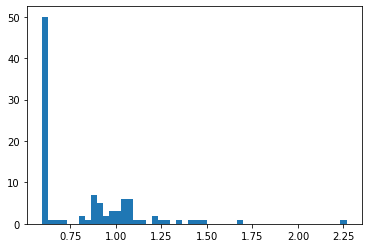

In [33]:
chi2_iteration = np.array(chi2_iteration)/(2*len(xpos_all)-15)
plt.hist(chi2_iteration,bins=50)
plt.show()

In [34]:
print(np.mean(chi2_iteration),np.std(chi2_iteration))
idx = np.where(chi2_iteration>0.65)
print(chi2_iteration[idx])

print("Success rate = ")
print(1 - len(chi2_iteration[idx])/len(chi2_iteration))

0.825909700324899 0.2965170415841043
[1.08883801 0.92656749 1.08126642 1.05082737 0.86469599 1.07973624
 1.15561408 0.97817029 1.01725368 1.22776732 1.06056725 0.80346145
 0.71256003 1.44127075 1.35422828 0.95410253 1.03827538 0.92633396
 1.06699543 1.69573168 0.806028   1.42289456 0.90452428 0.89382487
 2.26695003 0.87261242 0.66955402 1.03024909 1.03657904 1.02052417
 0.85979784 0.9650173  0.88532541 1.29406785 0.90856963 1.09541527
 0.97557729 1.23482703 0.89184537 1.20701349 1.05282125 1.10259442
 1.00822683 1.47418752 0.88953706 0.90491924 1.06689012 0.95696245
 0.88910695]
Success rate = 
0.51


## How close to period do we need to be?

In [ ]:
chi2_period = []
for pinner1 in tqdm(np.linspace(4.99,5.01,20)):
    
    params_inner1_test=np.empty(shape=(0,7))
    params_inner2_test=np.empty(shape=(0,7))
    params_outer_test=np.empty(shape=(0,7))
    chi2_test = np.empty(shape=0)

    for i in np.arange(50):
        ## randomize orbital elements
        bigw2 = np.random.uniform(0,360)
        inc2 = np.random.uniform(0,180)
        T2 = np.random.uniform(58000,60000)
        bigw3 = np.random.uniform(0,360)
        inc3 = np.random.uniform(0,180)
        T3 = np.random.uniform(58000,60000)

        params = Parameters()
        params.add('w',   value= w_start, min=0, max=360)
        params.add('bigw', value= bigw_start, min=0, max=360)
        params.add('inc', value= inc_start, min=0, max=180)
        params.add('e', value= e_start, min=0, max=0.99)
        params.add('a', value= a_start, min=0)
        params.add('P', value= P_start, min=0)
        params.add('T', value= T_start, min=0)
        params.add('w2',   value= 0, vary=False)
        params.add('bigw2', value= bigw2, min=0, max=360)
        params.add('inc2', value= inc2, min=0, max=180)
        params.add('e2', value= 0, vary=False)
        params.add('a2', value= a2, min=0)
        params.add('P2', value= pinner1, vary=False)
        params.add('T2', value= T2, min=0)
        
        params.add('w3',   value= 0, vary=False)
        params.add('bigw3', value= bigw3, min=0, max=360)
        params.add('inc3', value= inc3, min=0, max=180)
        params.add('e3', value= 0, vary=False)
        params.add('a3', value= a2, min=0)
        params.add('P3', value= 100, vary=False)
        params.add('T3', value= T3, min=0)
        
        if mirc_scale == 'y':
            params.add('mirc_scale', value= 1.0)
        else:
            params.add('mirc_scale', value= 1.0, vary=False)

        #params.add('pscale', value=1)

        #do fit, minimizer uses LM for least square fitting of model to data
        minner = Minimizer(quad_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                           error_maj_all,error_min_all,
                                                           error_pa_all),
                          nan_policy='omit')
        result = minner.leastsq(xtol=1e-5,ftol=1e-5)
        params_inner1_test = np.append(params_inner1_test,[result.params['P3'],result.params['a3'],result.params['e3'],result.params['w3'],
                                                           result.params['bigw3'],result.params['inc3'],result.params['T3']])
        params_inner2_test = np.append(params_inner2_test,[result.params['P2'],result.params['a2'],result.params['e2'],result.params['w2'],
                                                           result.params['bigw2'],result.params['inc2'],result.params['T2']])
        params_outer_test = np.append(params_outer_test,[result.params['P'],result.params['a'],result.params['e'],result.params['w'],
                                                         result.params['bigw'],result.params['inc'],result.params['T']])
        chi2_test = np.append(chi2_test,result.chisqr)
    
        #print(process.memory_info().vms*1e-9)

    idx = np.argmin(chi2_test)
    #idx_n = np.argmin(chi2_noise_n)
    chi2_quad_test = chi2_test[idx]
    #chi2_noise.append(chi2_noise_n[idx_n])
    params_inner1_test = params_inner1_test[idx]
    params_inner2_test = params_inner2_test[idx]
    params_outer_quad_test = params_outer_test[idx]
    
    chi2_period.append(chi2_quad_test)

In [ ]:
plt.plot(np.linspace(4.99,5.01,20),np.array(chi2_period)/(2*len(xpos_all)-15),'o--')
plt.show()

In [ ]:
##########################################
## Grid Search for Additional Companions
##########################################

## New test -- try period spacing from PHASES III paper
time_span = max(t) - min(t)
print('Time span of data = %s days'%time_span)
f = 5
min_per = 2
max_k = int(2*f*time_span / min_per)
k_range = np.arange(max_k)[:-1] + 1
P2 = 2*f*time_span / k_range
print('Min/Max period (days) = %s / %s ; %s steps'%(min(P2),max(P2),len(k_range)))

ss = 0.01
se = 1

a2 = resids_median/1000
if np.isnan(a2):
    a2=1
#T2 = 55075

## Or just input it yourself
P2 = np.linspace(2,8,50)
P3 = np.linspace(50,150,200)


## Double grid

In [ ]:
print('Grid Searching over period')
params_inner1=[]
params_inner2=[]
params_outer_quad=[]
chi2_quad = []

for period1 in tqdm(P2):
    for period2 in P3:

        params_inner1_n=np.zeros(shape=(20,7))
        params_inner2_n=np.zeros(shape=(20,7))
        params_outer_n=np.zeros(shape=(20,7))
        chi2_n = np.zeros(shape=20)

        for i in np.arange(20):
            ## randomize orbital elements
            bigw2 = np.random.uniform(0,360)
            inc2 = np.random.uniform(0,180)
            T2 = np.random.uniform(58000,60000)
            bigw3 = np.random.uniform(0,360)
            inc3 = np.random.uniform(0,180)
            T3 = np.random.uniform(58000,60000)

            params = Parameters()
            params.add('w',   value= w_start, min=0, max=360)
            params.add('bigw', value= bigw_start, min=0, max=360)
            params.add('inc', value= inc_start, min=0, max=180)
            params.add('e', value= e_start, min=0, max=0.99)
            params.add('a', value= a_start, min=0)
            params.add('P', value= P_start, min=0)
            params.add('T', value= T_start, min=0)
            params.add('w2',   value= 0, vary=False)
            params.add('bigw2', value= bigw2, min=0, max=360)
            params.add('inc2', value= inc2, min=0, max=180)
            params.add('e2', value= 0, vary=False)
            params.add('a2', value= a2, min=0)
            params.add('P2', value= period1, vary=False)
            params.add('T2', value= T2, min=0)
        
            params.add('w3',   value= 0, vary=False)
            params.add('bigw3', value= bigw3, min=0, max=360)
            params.add('inc3', value= inc3, min=0, max=180)
            params.add('e3', value= 0, vary=False)
            params.add('a3', value= a2, min=0)
            params.add('P3', value= period2, vary=False)
            params.add('T3', value= T3, min=0)
        
            if mirc_scale == 'y':
                params.add('mirc_scale', value= 1.0)
            else:
                params.add('mirc_scale', value= 1.0, vary=False)

            #params.add('pscale', value=1)

            #do fit, minimizer uses LM for least square fitting of model to data
            minner = Minimizer(quad_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                               error_maj_all,error_min_all,
                                                               error_pa_all),
                              nan_policy='omit')
            result = minner.leastsq(xtol=1e-5,ftol=1e-5)
            params_inner1_n[i] = [result.params['P3'],result.params['a3'],result.params['e3'],result.params['w3']
                                ,result.params['bigw3'],result.params['inc3'],result.params['T3']]
            params_inner2_n[i] = [result.params['P2'],result.params['a2'],result.params['e2'],result.params['w2']
                                ,result.params['bigw2'],result.params['inc2'],result.params['T2']]
            params_outer_n[i] = [result.params['P'],result.params['a'],result.params['e'],result.params['w']
                                ,result.params['bigw'],result.params['inc'],result.params['T']]
            chi2_n[i] = result.chisqr

        idx = np.argmin(chi2_n)
        #idx_n = np.argmin(chi2_noise_n)
        chi2_quad.append(chi2_n[idx])
        #chi2_noise.append(chi2_noise_n[idx_n])
        params_inner1.append(params_inner1_n[idx])
        params_inner2.append(params_inner2_n[idx])
        params_outer_quad.append(params_outer_n[idx])

In [ ]:
chi2_quad = np.array(chi2_quad)
params_inner1 = np.array(params_inner1)
params_inner2 = np.array(params_inner2)
params_outer_quad = np.array(params_outer_quad)


In [ ]:
print(chi2_quad.shape)

In [ ]:
plt.plot(params_inner1[:,0],1/chi2_quad)
plt.plot(params_inner2[:,0],1/chi2_quad)
plt.plot([pper1,pper1],[min(1/chi2_quad),max(1/chi2_quad)],'--',label='%s uas'%(psem1*1000))
plt.plot([pper2,pper2],[min(1/chi2_quad),max(1/chi2_quad)],'--',label='%s uas'%(psem2*1000))
plt.xlabel('Period (days)')
plt.ylabel('1/chi2')
plt.legend()
plt.show()

In [ ]:
plt.scatter(params_inner2[:,0],params_inner1[:,0],c=1/chi2_quad,cmap=cm.inferno)
plt.plot(pper2,pper1,'+')
plt.show()

idx = np.argmin(chi2_quad)
print("Best periods = ", params_inner2[:,0][idx],params_inner1[:,0][idx])